# Analysis of SEIRX model runs for test technology and vaccination ratios

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from os.path import join
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import analysis_functions as af

In [83]:
language = 'english'
vacc_scenarios = [(0.5, 0.0), (0.0, 0.5), (0.5, 0.9), (0.9, 0.9)]

## Mappings of variables to plot labels

In [84]:
# English
if language == 'english':
    frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

    test_name_map = {
        'same_day_antigen':'same-day antigen',
        'one_day_PCR':'one day PCR',
        'two_day_PCR':'two days PCR',
        'same_day_PCR':'same-day PCR',
        'same_day_LAMP':'same-day RT-LAMP'}

    metric_name_map = {
        'infected_residents_mean':'follow-up cases residents (mean)',
        'infected_residents_median':'follow-up cases residends (median)',
        'infected_residents_0.90':'follow-up cases residents (90th percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'follow-up cases residents'}

    index_case_map = {'employee':'index case employee',
                      'resident':'index case resident'}
    
    xlabel = 'screening frequency employees'
    ylabel = 'screening freuqency residents'
    
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']
    
    #vacc_scenario_labels = ['no vaccination', 'employees prioritised',
    #        'residents prioritised', 'high hesitancy', 'optimal vaccination']
    vacc_scenario_labels = ['no\nvaccination', 'emp. 50%\nres. 0%', 
                            'emp. 0%\nres. 50%',  'emp. 50%\nres. 90%',
                             'emp. 90%\nres. 90%']
    
    test_strat_labels = [ 'frequent testing employees',
                         'infrequent testing everybody']

# German
if language == 'german':
    frequency_name_map = {np.nan:'nie',
                  2:'3 mal\npro Woche',
                  3:'2 mal\npro Woche',
                  7:'ein mal\npro Woche'}

    test_name_map = {
        'same_day_antigen':'Antigen (selber Tag)',
        'one_day_PCR':'PCR (1 Tag)',
        'two_day_PCR':'PCR (2 Tage)',
        'same_day_PCR':'PCR (selber Tag)', 
        'same_day_LAMP':'RT-LAMP (selber Tag)'}

    metric_name_map = {
        'infected_residents_mean':'Folgefälle BewohnerInnen (Mittelwert)',
        'infected_residents_median':'Folgefälle BewohnerInnen (Median)',
        'infected_residents_0.90':'Folgefälle BewohnerInnen (90. Percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'Folgefälle BewohnerInnen'}

    index_case_map = {'employee':'Indexfall MitarbeiterIn',
                      'resident':'Indexfall BewohnerIn'}
    
    xlabel = 'Testfrequenz MitarbeiterInnen'
    ylabel = 'Testfrequenz BewohnerInnen'
    
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

    #vacc_scenario_labels = ['keine Impfungen',
    #                        'MitarbeiterInnen priorisiert',
    #                        'BewohnerInnen priorisiert',
    #                        'viele ImpfgegnerInnen',
    #                        'optimale Durchimpfung',
    #                        ]
    vacc_scenario_labels = ['keine\nImpfungen', 'Mit. 50%\nBew. 0%', 
                            'Mit. 0%\nBew. 50%',  'emp. 50%\nBew. 90%',
                             'Mit. 90%\Bew. 90%']
    
    test_strat_labels = ['häufiges Testen MitarbeiterInnen',
                         'seltenes Testen alle']

## Helper functions

In [85]:
def load_ensmbl(p, variant='wild_type'):
    test_type, index_case,\
    e_screen_interval, r_screen_interval, testing_strat_label, \
    e_vacc_ratio, r_vacc_ratio, vacc_scen_label = p
    
    ensmbl_dst = '../data/simulation_results/ensembles/testing_and_vaccination/{}'.format(variant)
    ensmbl_name = 'test-{}_index-{}_esi-{}_rsi-{}_evr-{}_rvr-{}.csv'

    ensmbl_file = ensmbl_name.format(test_type, index_case, e_screen_interval,
                r_screen_interval, e_vacc_ratio, r_vacc_ratio)
    
    ensmbl = pd.read_csv(join(ensmbl_dst, ensmbl_file))
    ensmbl['vaccination_scenario'] = vacc_scen_label
    ensmbl['testing_scenario'] = testing_strat_label + '\n' + \
        test_name_map[test_type]
    ensmbl['index_case'] = index_case
    ensmbl['infected_residents'] = ensmbl['E_resident'] + \
                                   ensmbl['I_resident'] + ensmbl['R_resident']
    
    return ensmbl

In [120]:
def load_baseline_ensmbl(p, variant='wild_type'):
    test_type, index_case, e_screen_interval, r_screen_interval,\
        testing_strat_label, vacc_strat_label = p
    
    e_vacc_ratio = 0
    r_vacc_ratio = 0
    
    baseline_ensmbl_dst = '../data/simulation_results/ensembles/testing_strategy/{}'\
        .format(variant)
    try:
        ensmbl_name = 'test-{}_index-{}_esi-{}_rsi-{}.csv'
        ensmbl_file = ensmbl_name.format(test_type, index_case, e_screen_interval,
                    r_screen_interval)
        ensmbl = pd.read_csv(join(baseline_ensmbl_dst, ensmbl_file))
        
    except FileNotFoundError:
        ensmbl_name = 'test-{}_index-{}_esi-{}_rsi-{}_evr-{}_rvr-{}.csv'
        ensmbl_file = ensmbl_name.format(test_type, index_case, e_screen_interval,
                    r_screen_interval, e_vacc_ratio, r_vacc_ratio)
        ensmbl = pd.read_csv(join(baseline_ensmbl_dst, ensmbl_file))
    

    
    ensmbl['vaccination_scenario'] = vacc_strat_label
    ensmbl['testing_scenario'] = testing_strat_label + '\n' + \
        test_name_map[test_type]
    ensmbl['index_case'] = index_case
    ensmbl['infected_residents'] = ensmbl['E_resident'] + \
                                   ensmbl['I_resident'] + ensmbl['R_resident']
    return ensmbl

In [111]:
def get_testing_scenario_data(df, testing_scenario):
    tmp = df[df['testing_scenario'] == testing_scenario]
    agg = tmp[['run', 'vaccination_scenario', 'index_case', 'infected_residents']]\
        .groupby(['run', 'vaccination_scenario', 'index_case'])\
        .agg('max')\
        .reset_index()\
        .drop(columns=['run'])
    agg.loc[agg['index_case'] == 'resident', 'infected_residents'] -= 1

    #agg['vaccination_scenario'] = pd.Categorical(agg['vaccination_scenario'], 
    #    categories=vacc_scenario_labels, ordered=True)

    return agg

In [100]:
def plot_testing_strategy_vaccination_scenario_grid(data, metric, screening_params,
                                        variant='', vmax=10, vmin=0, vstep=2):
    # figure layout & axis setup
    fig = plt.figure(figsize=(15, 20))
    gs = fig.add_gridspec(nrows=8, ncols=5, width_ratios=[1,1,1,1, 0.1],\
                    height_ratios=[0.1,1,0.1,1,0.1,1,0.1,1], wspace=0.05, hspace=0)

    title_ax_1 = fig.add_subplot(gs[0, 0:])
    hmap_ax_1 = fig.add_subplot(gs[1, 0])
    hmap_ax_2 = fig.add_subplot(gs[1, 1])
    hmap_ax_3 = fig.add_subplot(gs[1, 2])
    hmap_ax_4 = fig.add_subplot(gs[1, 3])

    title_ax_2 = fig.add_subplot(gs[2, 0:])
    hmap_ax_5 = fig.add_subplot(gs[3, 0])
    hmap_ax_6 = fig.add_subplot(gs[3, 1])
    hmap_ax_7 = fig.add_subplot(gs[3, 2])
    hmap_ax_8 = fig.add_subplot(gs[3, 3])

    title_ax_3 = fig.add_subplot(gs[4, 0:])
    hmap_ax_9 = fig.add_subplot(gs[5, 0])
    hmap_ax_10 = fig.add_subplot(gs[5, 1])
    hmap_ax_11 = fig.add_subplot(gs[5, 2])
    hmap_ax_12 = fig.add_subplot(gs[5, 3])

    title_ax_4 = fig.add_subplot(gs[6, 0:])
    hmap_ax_13 = fig.add_subplot(gs[7, 0])
    hmap_ax_14 = fig.add_subplot(gs[7, 1])
    hmap_ax_15 = fig.add_subplot(gs[7, 2])
    hmap_ax_16 = fig.add_subplot(gs[7, 3])

    cbar_ax = fig.add_subplot(gs[3:7, 4])

    hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3, hmap_ax_4],
                 [hmap_ax_5, hmap_ax_6, hmap_ax_7, hmap_ax_8],
                 [hmap_ax_9, hmap_ax_10, hmap_ax_11, hmap_ax_12],
                 [hmap_ax_13, hmap_ax_14, hmap_ax_15, hmap_ax_16]]

    title_axes = [title_ax_1, title_ax_2, title_ax_3, title_ax_4]

    # possible range of median outbreak sizes to fix the dynamic range of the
    # colormaps
    vmin=0
    vstep=1

    # compare scenarios in which either employees or residents are the index case
    for i, index_case_mode, test_type in zip([0, 1, 2, 3],
            ['employee', 'resident', 'employee', 'resident'],
            ['same_day_antigen','same_day_antigen','same_day_LAMP','same_day_LAMP']):

        df = data.loc[test_type, index_case_mode, :, :]

        # remove all axis labels and ticks for the heatmaps
        t_ax = title_axes[i]
        t_ax.set_xticks([])
        t_ax.set_yticks([])
        t_ax.set_frame_on(False)
        t_ax.set_xlim(0, 1)
        t_ax.set_ylim(0, 3)
        t_ax.text(0.23, 1, 'Test: {}, '.format(test_name_map[test_type]) +\
                  index_case_map[index_case_mode], fontsize=20)

        j = 0
        # compare same-day turnover testing for different testing technologies
        for j, ax, vacc_scenario, vacc_scenario_label in zip(range(4), hmap_axes[i],
                                    vacc_scenarios, vacc_scenario_labels):

            # set flag to set axis ticks only for heatmaps at the boundaries of 
            # the figure
            xticks = False
            yticks = False
            if i > 2:
                xticks = True
            if j in [0, 4]:
                yticks = True

            # put the testing technology in the heatmap title
            ax.set_title(vacc_scenario_label.replace('\n', ' '), fontsize=14)

            # plot heatmap of the scenario
            img = af.get_image(df.loc[vacc_scenario[0]], vacc_scenario[1],
                            screening_params, metric)
            if index_case_mode == 'resident':
                # if a resident is the index case, we need to subtract 1 from the
                # number of infected residents, to calculate the "outbreak size",
                # which is defined as the number of FOLLOW-UP cases, given an index
                # case
                img = img - 1
            img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax, xticks,
                                    yticks, xlabel, ylabel)

            # annotate heatmap with tests / days / agent
            test_rate = af.get_image(df.loc[vacc_scenario[0]],
                    vacc_scenario[1], screening_params, 'test_rate_mean')

            af.annotate_heatmap(ax, test_rate)

    # colorbar
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                            ticks=np.arange(vmin, vmax + 1, vstep))
    yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
    cbar.ax.set_yticklabels(yticklabels)
    cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)     

    plt.savefig(join(dst_path, 'testing_strategy_and_vaccinations_{}{}.png'\
                     .format(variant, language[0:3])), dpi=300, transparent=True)
    plt.savefig(join(dst_path, 'testing_strategy_and_vaccinations_{}{}.pdf'\
                     .format(variant, language[0:3])), transparent=True)

In [126]:
def plot_violins(data, metric, testing_scenarios, vaccination_scenarios,
                 variant='', ymin=-3, ymax=20):
    fig = plt.figure(figsize=(10, 7.5))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.1, hspace=0.4)

    for i, testing_scenario in enumerate(testing_scenarios):
        ax = plt.subplot(gs[int(i/2), i%2])
        agg = get_testing_scenario_data(data, testing_scenario)
        agg = agg[agg['vaccination_scenario'].isin(vaccination_scenarios)]
        sns.violinplot(x='vaccination_scenario', y=metric, 
                  hue='index_case', data=agg, split=True, ax=ax,
                  palette=['FireBrick', 'DarkBlue'], order=vaccination_scenarios)

        ax.set_xlabel('')
        ax.text(2.4, 17, testing_scenario, ha='center',
               fontsize=10)
        ax.set_ylim(ymin, ymax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if i in [1, 3]:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
            if i == 1:
                l = ax.legend(title='index case', loc=2, 
                          bbox_to_anchor=[-0.3, -0.3, 1, 1], fontsize=10)
                l.get_title().set_fontsize(10)
            else:
                ax.legend([], [], frameon=False)
        else:
            ax.set_ylabel(metric_name_map[metric])
            ax.legend([], [], frameon=False)
            
        for violin in ax.collections[::]:
            violin.set_alpha(0.7)

    fig.text(0.135, 0.87, 'A', fontweight='bold', fontsize=14)
    fig.text(0.535, 0.87, 'B', fontweight='bold', fontsize=14)
    fig.text(0.135, 0.425, 'C', fontweight='bold', fontsize=14)
    fig.text(0.535, 0.425, 'D', fontweight='bold', fontsize=14)
    plt.savefig('../plots/vaccination_scenario_violins_{}{}.pdf'\
                .format(variant, language[0:3]), transparent=True)
    plt.savefig('../plots/vaccination_scenario_violins_{}{}.png'\
                .format(variant, language[0:3]), dpi=300)

## Analysis wild type

### Load the simulation results

In [90]:
N_runs = 1000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [91]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

### Colormaps for different vaccination scenarios

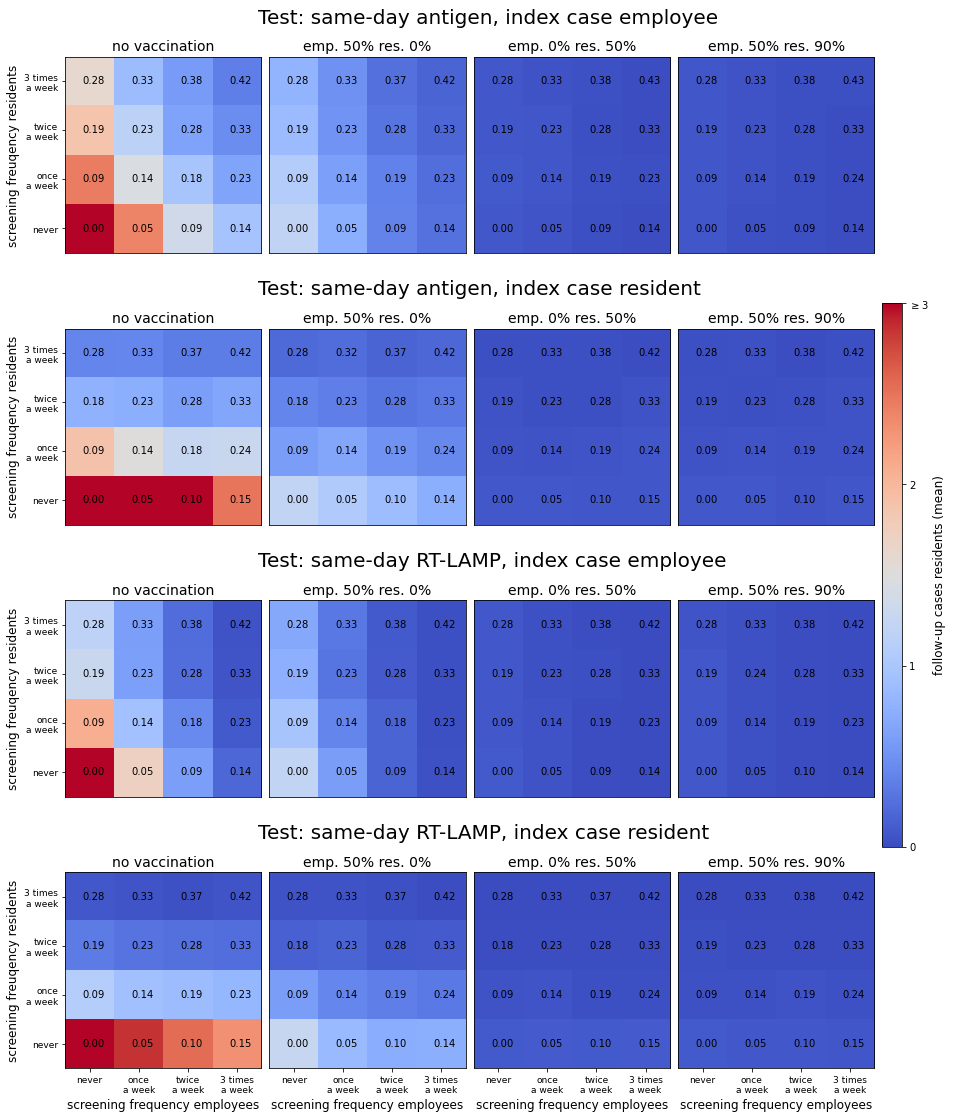

In [94]:
plot_testing_strategy_vaccination_scenario_grid(\
                       data, 'infected_residents_mean', screening_intervals)

### Violin plots

**Realistic scenarios**
* Employees screened 2x / week, residents never, index resident
* Employees screened 2x / week, residents never, index employee
* Employees screened 1x / week, residents screened 1x / week, index resident
* Employees screened 1x / week, residents screened 1x / week, index employee

In [67]:
test_types = ['same_day_antigen', 'same_day_LAMP']
index_cases = ['employee', 'resident']
vaccination_scenarios = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.0, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = [
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]]]

In [68]:
# load the vaccination scenario X testing strategy data
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, load_ensmbl(p)])

In [69]:
# load the baseline data (only testing strategies)
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, load_baseline_ensmbl(p)])

In [70]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls])

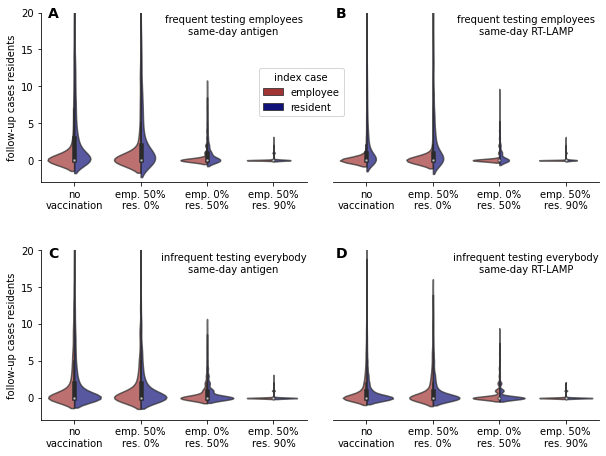

In [81]:
plot_violins(ensmbls, 'infected_residents', testing_scenarios, vacc_scenario_labels[0:4])

### Outbreak sizes

#### Employees screened 1x / week

In [45]:
res_prio = data.loc[:, :, 0.0, 0.5, :, :]
emp_prio = data.loc[:, :, 0.5, 0.0, :, :]
high_hesitancy = data.loc[:, :, 0.5, 0.9, :, :]
opt_vacc = data.loc[:, :, 0.9, 0.9, :, :]

##### Same-day antigen

**Resident priority**

In [48]:
# employee index case
mean = res_prio.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = res_prio.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7584 +- 1.6678686390598727


In [50]:
# resident index case
mean = res_prio.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = res_prio.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9550000000000001 +- 1.745733231883778


**Employee priority**

In [51]:
# employee index case
mean = emp_prio.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = emp_prio.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.153 +- 4.2429696626669


In [52]:
# resident index case
mean = emp_prio.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = emp_prio.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.8954 +- 4.484872535126418


**High hesitancy**

In [53]:
# employee index case
mean = high_hesitancy.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = high_hesitancy.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0644 +- 0.2650786550038832


In [54]:
# resident index case
mean = high_hesitancy.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = high_hesitancy.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.10240000000000005 +- 0.3375455930766703


**Optimal vaccination**

In [55]:
# employee index case
mean = opt_vacc.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = opt_vacc.loc['same_day_antigen', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0582 +- 0.2569551812924553


In [56]:
# resident index case
mean = opt_vacc.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = opt_vacc.loc['same_day_antigen', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0858000000000001 +- 0.2980874556673683


##### Same-day LAMP

**Resident priority**

In [57]:
# employee index case
mean = res_prio.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = res_prio.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5076 +- 1.2692771379374082


In [58]:
# resident index case
mean = res_prio.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = res_prio.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9643999999999999 +- 1.704615435444767


**Employee priority**

In [59]:
# employee index case
mean = emp_prio.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = emp_prio.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.7076 +- 3.8011303527229474


In [60]:
# resident index case
mean = emp_prio.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = emp_prio.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.7626 +- 4.325642550731087


**High hesitancy**

In [61]:
# employee index case
mean = high_hesitancy.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = high_hesitancy.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0514 +- 0.2382632868882148


In [62]:
# resident index case
mean = high_hesitancy.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = high_hesitancy.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08519999999999994 +- 0.299931578514764


**Optimal vaccination**

In [63]:
# employee index case
mean = opt_vacc.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_mean']
std = opt_vacc.loc['same_day_LAMP', 'employee', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0436 +- 0.2202470016784556


In [64]:
# resident index case
mean = opt_vacc.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_mean'] - 1
std = opt_vacc.loc['same_day_LAMP', 'resident', 'once\na week', 'never']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08739999999999992 +- 0.3055812755768858


## Analysis B.1.1.7

### Load the simulation results

In [97]:
N_runs = 1000
sim_name = 'simulations_testing_and_vaccination_UK_variant_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [98]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

### Colormaps for different vaccination scenarios

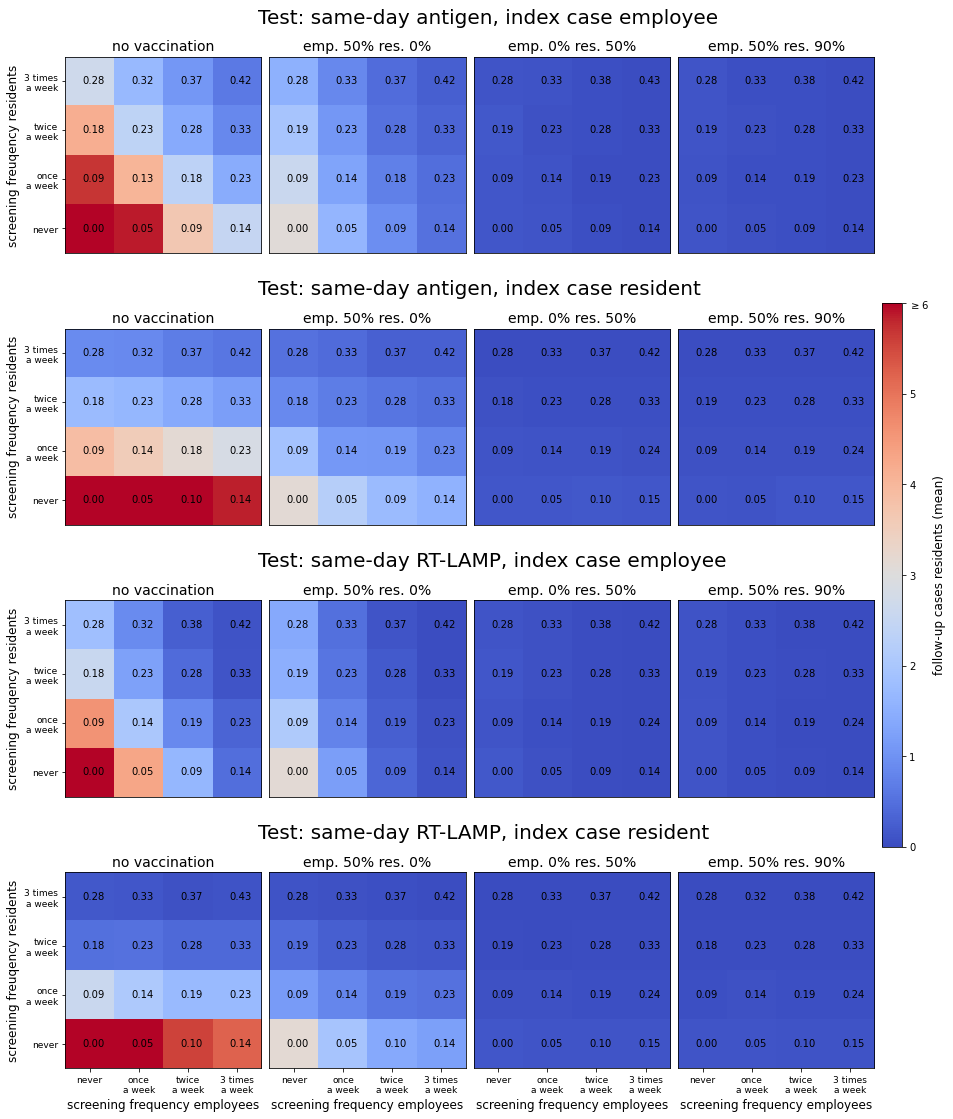

In [104]:
plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals, variant='_UK_variant', vmax=6,
                                               vstep=1)

### Violin plots

**Realistic scenarios**
* Employees screened 2x / week, residents never, index resident
* Employees screened 2x / week, residents never, index employee
* Employees screened 1x / week, residents screened 1x / week, index resident
* Employees screened 1x / week, residents screened 1x / week, index employee

In [112]:
test_types = ['same_day_antigen', 'same_day_LAMP']
index_cases = ['employee', 'resident']
vaccination_scenarios = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.0, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = [
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]]]

In [113]:
# load the vaccination scenario X testing strategy data
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, load_ensmbl(p, variant='UK_variant')])

In [121]:
# load the baseline data (only testing strategies)
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                                  load_baseline_ensmbl(p, variant='UK_variant')])

In [122]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls])

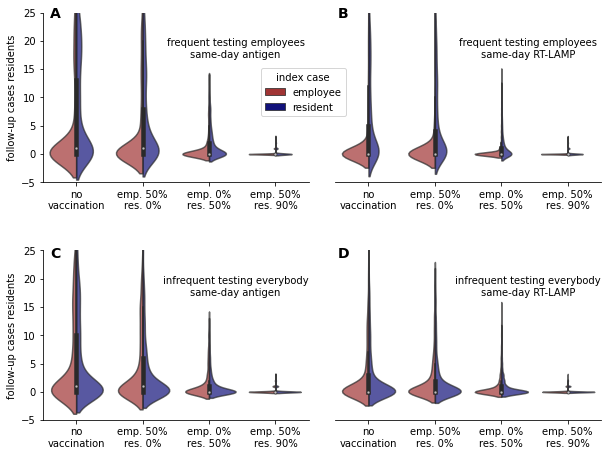

In [127]:
plot_violins(ensmbls, 'infected_residents', testing_scenarios,
             vacc_scenario_labels[0:4], ymin=-5, ymax=25)